<a href="https://colab.research.google.com/github/samaneh-m/Monte-Carlo-simulation/blob/main/MC%2BSNIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade pip
!pip install "bayesflow>=2.0"
!pip install tensorflow
!pip install hmmlearn
!pip install scikit-learn
!pip install pandas matplotlib scipy


In [2]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"


In [3]:
import tensorflow as tf
import bayesflow as bf
import hmmlearn

print("TensorFlow version:", tf.__version__)
print("BayesFlow version:", bf.__version__)
print("GPU available:", tf.config.list_physical_devices("GPU"))


INFO:bayesflow:Using backend 'tensorflow'


TensorFlow version: 2.19.0
BayesFlow version: 2.0.7
GPU available: []


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm


In [5]:
class HMMHiddenStateSimulator:
    def __init__(self, seq_len=50):
        self.seq_len = seq_len

        self.transmat = np.array([
            [0.90, 0.10],
            [0.05, 0.95]
        ])

        self.startprob = np.array([0.0, 1.0])

        emissions = {
            'alpha': np.array([12,6,3,5,1,9,5,4,2,7,12,6,3,4,2,5,4,1,3,6]) / 100,
            'other': np.array([6,5,5,6,2,5,3,9,3,5,8,6,2,4,6,7,6,1,4,7]) / 100
        }

        self.emissionprob = np.stack([
            emissions['alpha'],
            emissions['other']
        ])

        self.model = hmm.CategoricalHMM(
            n_components=2,
            init_params=""
        )

        self.model.startprob_ = self.startprob
        self.model.transmat_ = self.transmat
        self.model.emissionprob_ = self.emissionprob

    def sample(self, n_sequences=1):
        Z = []
        for _ in range(n_sequences):
            _, states = self.model.sample(self.seq_len)
            Z.append(states.flatten())
        return np.array(Z)

In [6]:
# ===============================
# NEW: Proposal HMM (q)
# ===============================

class HMMHiddenStateSimulatorIS(HMMHiddenStateSimulator):
    def __init__(self, seq_len=50):
        super().__init__(seq_len)

        # Tilt transitions to favor alpha-helix persistence
        self.transmat = np.array([
            [0.85, 0.15],
            [0.03, 0.97]
        ])

        self.model.transmat_ = self.transmat

In [9]:
# Sanity check the simulator
sim = HMMHiddenStateSimulator(seq_len=50)
z = sim.sample(n_sequences=5)

print("Hidden states shape:", z.shape)
print("First hidden state sequence:")
print(z[0])


Hidden states shape: (5, 50)
First hidden state sequence:
[1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 0 0 0]


In [10]:
#Implement the estimand
def helix_probability(hidden_states):
    return hidden_states.mean(axis=1)

In [11]:
# ===============================
# Log-probability of HMM path
# ===============================
def log_hmm_prob(states, transmat, startprob):
    logp = np.log(startprob[states[0]])
    for t in range(1, len(states)):
        logp += np.log(transmat[states[t-1], states[t]])
    return logp

In [12]:
#Sanity check on simulated data
theta = helix_probability(z)

print("Helix probabilities:")
print(theta)
print("Range:", theta.min(), theta.max())


Helix probabilities:
[0.58 0.74 0.58 0.8  0.3 ]
Range: 0.3 0.8


In [13]:
# ===============================
# Crude Monte Carlo estimator
# ===============================
def monte_carlo_helix_estimate(simulator, N):
    Z = simulator.sample(N)
    return helix_probability(Z).mean()

In [14]:
# ===============================
# NEW: Self-Normalized IS estimator
# ===============================
def snis_helix_estimate(sim_p, sim_q, N):
    Z = sim_q.sample(N)

    h = helix_probability(Z)
    weights = []

    for z in Z:
        log_p = log_hmm_prob(z, sim_p.transmat, sim_p.startprob)
        log_q = log_hmm_prob(z, sim_q.transmat, sim_q.startprob)
        weights.append(np.exp(log_p - log_q))

    weights = np.array(weights)
    weights /= weights.sum()

    return np.sum(weights * h)

In [15]:
# ===============================
# Experiment: MC vs SNIS
# ===============================
Ns = [50, 100, 200, 500, 1000]

sim_p = HMMHiddenStateSimulator()
sim_q = HMMHiddenStateSimulatorIS()

mc_vals = []
snis_vals = []

for N in Ns:
    mc_vals.append(monte_carlo_helix_estimate(sim_p, N))
    snis_vals.append(snis_helix_estimate(sim_p, sim_q, N))
    print(f"N={N:4d} | MC={mc_vals[-1]:.4f} | SNIS={snis_vals[-1]:.4f}")


N=  50 | MC=0.7012 | SNIS=0.6573
N= 100 | MC=0.7052 | SNIS=0.6951
N= 200 | MC=0.7231 | SNIS=0.6894
N= 500 | MC=0.7029 | SNIS=0.6927
N=1000 | MC=0.7135 | SNIS=0.7131


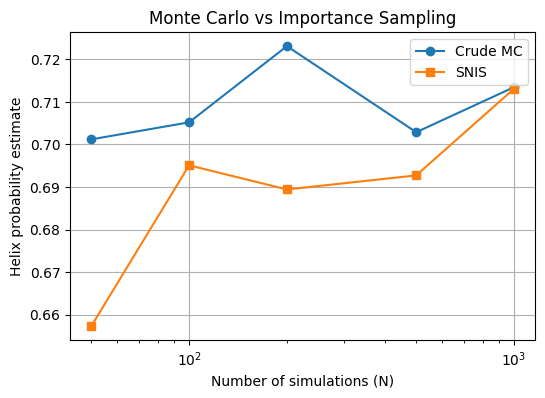

In [16]:
# ===============================
# Plot
# ===============================
plt.figure(figsize=(6,4))
plt.plot(Ns, mc_vals, marker='o', label="Crude MC")
plt.plot(Ns, snis_vals, marker='s', label="SNIS")
plt.xscale("log")
plt.xlabel("Number of simulations (N)")
plt.ylabel("Helix probability estimate")
plt.title("Monte Carlo vs Importance Sampling")
plt.legend()
plt.grid(True)
plt.show()

In [17]:
#Estimate Monte Carlo variance at fixed 𝑁
def mc_variance_estimate(simulator, N, R=50):
    """
    Estimate variance of MC estimator by repetition.

    simulator: HMMHiddenStateSimulator
    N: number of simulations per MC run
    R: number of repeated MC runs
    """
    estimates = []
    for _ in range(R):
        est = monte_carlo_helix_estimate(simulator, N)
        estimates.append(est)
    return np.var(estimates, ddof=1)


In [18]:
#Compute variance for increasing N
Ns = [50, 100, 200, 500, 1000, 2000]
variances = []

sim = HMMHiddenStateSimulator(seq_len=50)

for N in Ns:
    var_N = mc_variance_estimate(sim, N, R=50)
    variances.append(var_N)
    print(f"N={N:4d}  Var={var_N:.6f}")


N=  50  Var=0.000838
N= 100  Var=0.000308
N= 200  Var=0.000243
N= 500  Var=0.000089
N=1000  Var=0.000034
N=2000  Var=0.000015


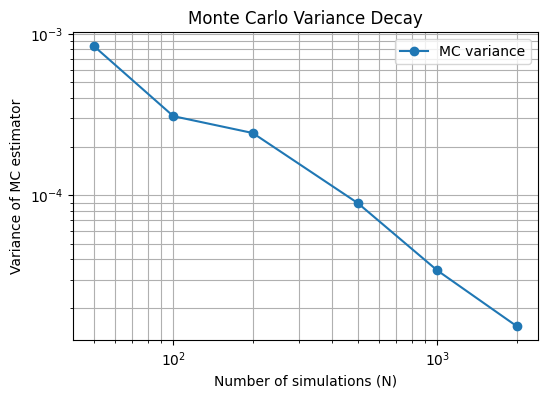

In [19]:
#Plot variance decay
plt.figure(figsize=(6,4))
plt.plot(Ns, variances, marker='o', label="MC variance")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of simulations (N)")
plt.ylabel("Variance of MC estimator")
plt.title("Monte Carlo Variance Decay")
plt.grid(True, which="both")
plt.legend()
plt.show()


partner 2

In [20]:
#Fix a realistic Monte Carlo sample size
N_fixed = 500


In [21]:
# Generate one Monte Carlo sample (Crude MC, target HMM)
sim = HMMHiddenStateSimulator(seq_len=50)
hidden_states = sim.sample(n_sequences=N_fixed)

# Per-sequence helix proportions θ^(n)
theta_samples = helix_probability(hidden_states)

# Monte Carlo point estimate
theta_hat = theta_samples.mean()

print("Point estimate (MC mean):", theta_hat)

Point estimate (MC mean): 0.7104400000000001


In [22]:
# Bootstrap the estimator (finite-sample uncertainty)
def bootstrap_ci(data, B=1000, alpha=0.05):
    """
    data: array of per-sequence helix proportions θ^(n), shape (N,)
    B: number of bootstrap resamples
    alpha: significance level for (1-alpha) CI

    returns:
        lower: lower CI bound
        upper: upper CI bound
        boot_means: bootstrap distribution of the MC mean
    """
    N = len(data)
    boot_means = []

    for _ in range(B):
        resample = np.random.choice(data, size=N, replace=True)
        boot_means.append(resample.mean())

    lower = np.percentile(boot_means, 100 * alpha / 2)
    upper = np.percentile(boot_means, 100 * (1 - alpha / 2))

    return lower, upper, boot_means


In [23]:
# Compute bootstrap CI
ci_lower, ci_upper, boot_means = bootstrap_ci(theta_samples)

print(f"95% Bootstrap CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
print("CI width:", ci_upper - ci_lower)


95% Bootstrap CI: [0.6927, 0.7284]
CI width: 0.035686000000000107


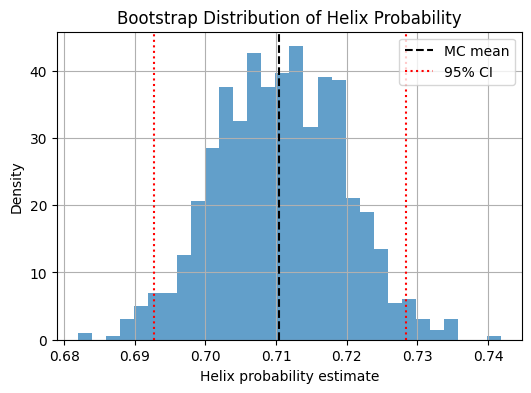

In [24]:
#Visualize bootstrap distribution
plt.figure(figsize=(6,4))
plt.hist(boot_means, bins=30, density=True, alpha=0.7)
plt.axvline(theta_hat, color='black', linestyle='--', label="MC mean")
plt.axvline(ci_lower, color='red', linestyle=':')
plt.axvline(ci_upper, color='red', linestyle=':', label="95% CI")
plt.xlabel("Helix probability estimate")
plt.ylabel("Density")
plt.title("Bootstrap Distribution of Helix Probability")
plt.legend()
plt.grid(True)
plt.show()


In [25]:
# Bootstrap CI width for increasing N
Ns = [50, 100, 200, 500, 1000]
ci_widths = []

sim = HMMHiddenStateSimulator(seq_len=50)

for N in Ns:
    hidden_states = sim.sample(n_sequences=N)  # <-- FIX: no unpacking
    theta_samples = helix_probability(hidden_states)

    ci_l, ci_u, _ = bootstrap_ci(theta_samples, B=1000)
    width = ci_u - ci_l
    ci_widths.append(width)

    print(f"N={N:4d}  CI width={width:.4f}")


N=  50  CI width=0.1140
N= 100  CI width=0.0838
N= 200  CI width=0.0549
N= 500  CI width=0.0381
N=1000  CI width=0.0276


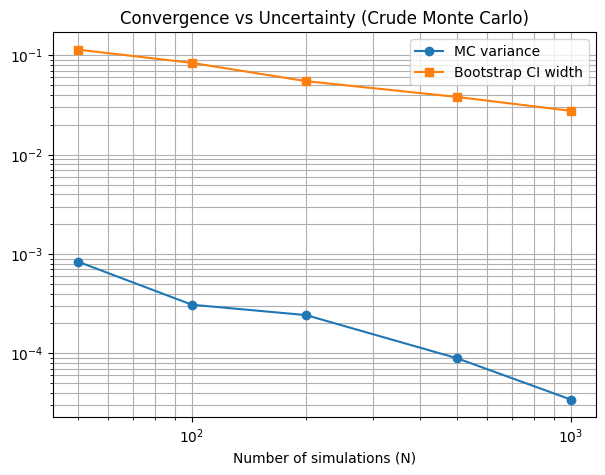

In [26]:
# Side-by-side comparison plot: Convergence vs Uncertainty (Crude MC)
plt.figure(figsize=(7,5))

# Match variance values to the same Ns used for CI widths
plt.plot(Ns, variances[:len(Ns)], marker='o', label="MC variance")
plt.plot(Ns, ci_widths, marker='s', label="Bootstrap CI width")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of simulations (N)")
plt.title("Convergence vs Uncertainty (Crude Monte Carlo)")
plt.grid(True, which="both")
plt.legend()
plt.show()
